# 09-PSF_Phot

Here I benchmarked the DAOPHOT (originally called DAOPHOT II) by P. B. Stetson, which is implemented to [IRAF's psf noao.digiphot.daophot](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?psf).

In [1]:
from pathlib import Path
import numpy as np

from astropy.io import fits

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils.detection import DAOStarFinder
from photutils.psf.groupstars import DAOGroup
from photutils.psf import FittableImageModel
from photutils.utils import random_cmap
cmap = random_cmap(random_state=12345)

from scipy.interpolate import RectBivariateSpline

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import FormatStrFormatter

from astropy.visualization import ZScaleInterval, ImageNormalize, LinearStretch
from astropy.stats import sigma_clipped_stats
from astropy.nddata import CCDData, Cutout2D
from astropy.table import Table, vstack
from astropy.modeling.fitting import LevMarLSQFitter

import ysfitsutilpy as yfu
import ysphotutilpy as ypu

plt.style.use('default')
rcParams.update({'font.size':12})

from matplotlib import pyplot as plt

def colorbaring(fig, ax, im, fmt="%d"):
    cb = fig.colorbar(im, ax=ax, orientation='horizontal', format=FormatStrFormatter(fmt))
    return cb

def znorm(image, stretch=LinearStretch(), **kwargs):
    return ImageNormalize(image, interval=ZScaleInterval(**kwargs), stretch=stretch)


def zimshow(ax, image, stretch=LinearStretch(), cmap=None, **kwargs):
    return ax.imshow(image, norm=znorm(image, stretch=stretch, **kwargs), origin='lower', cmap=cmap)

PSFPATH = Path("tmp/psf_01.fits")
PHOTPSFPATH = Path("tmp/psf_01.csv")
DATAPATH = Path("tmp/SNUO_STX16803-M11-1-1-20190507-171622-V-60.0_CR.fits")
FITTER = LevMarLSQFitter()

phot_psf = Table.read(PHOTPSFPATH)
psfccd = yfu.load_ccd(PSFPATH)
psfhdr = psfccd.header
PSF_OVERSAMPLE = psfhdr["OVERSAMP"]
psf_init = FittableImageModel(data=psfccd.data,
                              oversampling=PSF_OVERSAMPLE,
                              normalize=True,
                              ikwargs={"degree":[3, 3], "s":0})

fwhm = psfhdr["FWHM"]
psf_size = psfhdr["PSFSIZE"]
r_fit = fwhm # max(2, min(fwhm, 5))

ccd = yfu.load_ccd(DATAPATH)
hdr = ccd.header
err = yfu.make_errmap(ccd=ccd, gain_epadu=hdr["GAIN"], rdnoise_electron=hdr["RDNOISE"])
data = ccd.data

ccd.uncertainty = err

INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]


## Test Initial PSF Stars

In [2]:
cuts = dict(cut=[], err=[], fit=[])


for row in phot_psf:
    pos = (row["xcentroid"], row["ycentroid"])        
#     pos_cut = cut.to_cutout_position(pos)
    scut = Cutout2D(data, position=pos, size=3 * psf_size)  # "subtraction" cut

    result = ypu.dao_nstar(data=scut.data, 
                           position=scut.to_cutout_position(pos), 
                           r_fit=r_fit, 
                           psf=psf_init,
                           flux_init=row["source_sum"], 
                           sky=row["msky"], 
                           err=err, 
                           full=True)
    fit, pos_fit, fitter, astropy_weight, fcut, fcut_skysub, fcut_err = result

    yy_sub, xx_sub = np.mgrid[:scut.data.shape[1], :scut.data.shape[0]]
    star = fit(xx_sub, yy_sub)
    
    cuts["cut"].append(scut)
    cuts["err"].append(fcut_err)
    cuts["fit"].append(star)

cuts_tab = Table(cuts)

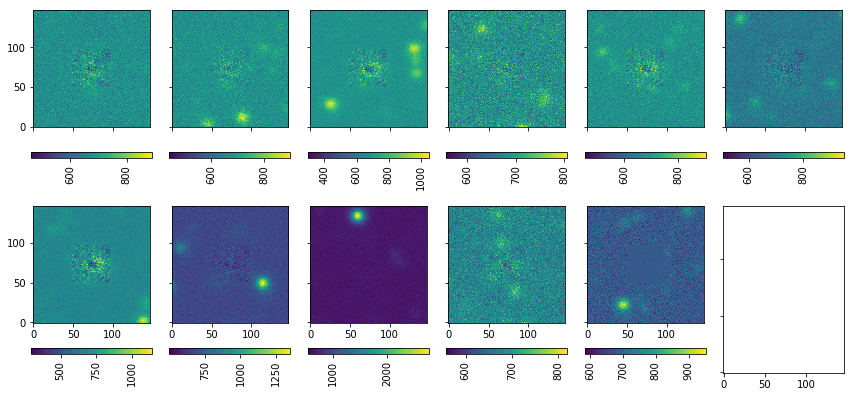

In [3]:
ncol = 6
nrow = max(len(cuts_tab) // ncol + 1, 1)
fig, axs = plt.subplots(nrow, ncol, figsize=(12, 2.8 * nrow), sharex=True, sharey=True)

for i, row in enumerate(cuts_tab):
    # Figure plotting
    irow = i // ncol
    icol = i - irow * ncol
    ax = axs[irow, icol]
#     posstr = f"({row['xcentroid']:.1f}, {row['ycentroid']:.1f})"
    
    # For showing bright star for PSF, it's better to set high vmin, not zscale,
    # because the central structure near the star cneter is important.
    im = ax.imshow(row["cut"].data - row["fit"], origin='lower')
    cb = colorbaring(fig, ax, im)
    plt.setp(cb.ax.get_xticklabels(),rotation=90)
    
plt.tight_layout()


Although not perfectly satisfactory, I will proceed the PSF photometry using this initial PSF. If you want better results, you should do the following:

1. For each PSF stars above, you may see some nearby stars after this initial star subtraction. 
2. Using our initial PSF (say PSF_01), fit PSF_01 to the nearby fainter stars.
3. Subtract the fitted profile.
4. Use this nearby-star-subtracted image to get the PSF as we did in the previous notebook.
5. Get PSF_02
6. Redo these until you are satisfied.

(same as [IRAF psf](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?psf))

Although PSF_01 will be different from the true PSF (PSF_0), the difference (PSF_0 - PSF_01) will be large only at the wing part, not the core part. The stars nearby our PSF stars must be much fainter than our PSF stars, and thus the contribution of their wing must be small compared to the PSF stars' core parts. This is why we can proceed the iteration by subtracting the nearby star using PSF_01, not PSF_0. 

```python
################# FOR TEST #################
ccd = CCDData(data=ccd.data[1000:2000,1000:2000],#[2000:3000,2000:3000], ################# FOR TEST #################
              uncertainty=err[1000:2000,1000:2000],#[2000:3000,2000:3000], ################# FOR TEST #################
              header=ccd.header, unit='adu')

ccd.data = np.pad(ccd.data, pad_width=psf_size//2, mode='constant',
                  constant_values=np.nan)
ccd.uncertainty.array = np.pad(ccd.uncertainty.array, pad_width=psf_size//2, mode='constant',
                               constant_values=np.nan)
############################################
```

In [4]:
err = yfu.make_errmap(ccd=ccd, gain_epadu=hdr["GAIN"], rdnoise_electron=hdr["RDNOISE"])
data = ccd.data

avg, med, std = sigma_clipped_stats(data, sigma=3, maxiters=10, std_ddof=1)
threshold = med - 5 * std
print(avg, med, std, threshold)

finder = DAOStarFinder(fwhm=fwhm, threshold=threshold,
                       sharplo=0., sharphi=2.0,   # default values 0.2 and 1.0
                       roundlo=-1.0, roundhi=1.0,  # default values -1 and +1
                       sigma_radius=2.5,           # default values 1.5
                       ratio=1.0,                  # 1.0: circular gaussian
                       exclude_border=True)        # To exclude sources near edges

# The DAOStarFinder object ``finder`` gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
found = finder(data)

# Select only the stars NOT at the edges (bezel) of the image
found = found[(found["xcentroid"] > psf_size)
             & (found["xcentroid"] < ccd.header["NAXIS1"] - psf_size)
             & (found["ycentroid"] > psf_size)
             & (found["ycentroid"] < ccd.header["NAXIS2"] - psf_size)]

# This needs to be updated by photutils....
found["id"] = np.arange(len(found)) + 1  

star_groups = ypu.group_stars(table=found,
                              crit_separation=2.8 * fwhm, 
                              xcol="xcentroid",
                              ycol="ycentroid",
                              index_only=False)

684.0113 683.18945 26.844547 548.9667167663574


* **QUESTION**: See what error you will get if you comment out the line ``found["id"] = np.arange(len(found)) + 1``.

1344 star groups out of 1653 stars


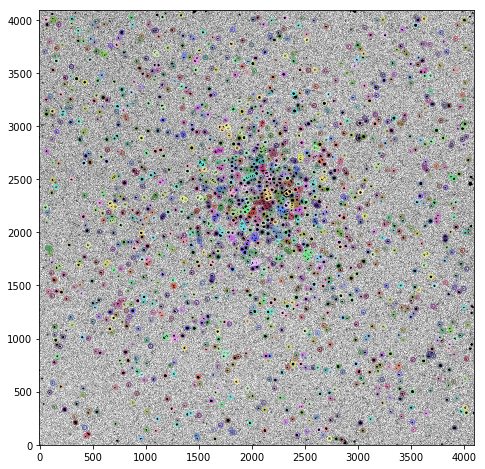

<Figure size 432x288 with 0 Axes>

In [5]:
coords_SF = (found['xcentroid'], found['ycentroid'])
ap_found = CAp(coords_SF, r=25) 

print(f"{len(star_groups.groups)} star groups out of {len(star_groups)} stars")

fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharex=False, sharey=False, gridspec_kw=None)
zimshow(axs, data, cmap="gray_r")

for i, group in enumerate(star_groups.groups):
    xypos = np.transpose([group['x_0'], group['y_0']])
    ap = CAp(xypos, r=20)
    ap.plot(color=cmap.colors[i%256], lw=1)
plt.show()

plt.tight_layout()

In [6]:
r_fit = 5 # max(2, min(fwhm, 5))
fbox = 2 * r_fit + 1 # fitting box size
r_in = 4 * fwhm
r_out = 6 * fwhm

xypos = np.transpose([star_groups['x_0'], star_groups['y_0']])
ap = CAp(xypos, r=r_fit)
an = CAn(xypos, r_in=r_in, r_out=r_out)
phot = ypu.apphot_annulus(ccd, aperture=ap, annulus=an, error=err,
                          sky_keys={"mode_option":"MMM"})
phot["group_id"] = star_groups["group_id"]
phot = Table(phot)

In [7]:
phot

<Table length=1653>
  id       xcenter            ycenter       ...          merr         group_id
             pix                pix         ...                               
int64      float64            float64       ...        float64         int64  
----- ------------------ ------------------ ... --------------------- --------
    1  2848.957456377571  51.56822969127648 ...  0.010150587118078227        1
    2 2798.7993033084576  56.98446334368872 ...  0.008573212693618439        2
    3  2731.699861723366  57.75837027679825 ...  0.026207820617202927        3
    4 1655.3184997497005 58.347353068201656 ...  0.008093207988482272        4
    5  957.9874802636899  60.14492490191232 ...    0.0215499851619153        5
    6 1489.0702514640313  60.47337491248807 ...   0.02371243921674443        6
    7 1478.1523822215881  86.09008982449117 ...  0.026840871055317905        6
    8  438.0290146914016  81.55705083352616 ...   0.02734977364172932        7
    9 459.91412506091757 101.69444567358809 ... 0.0024016643367377696        7
  ...                ...                ... ...                   ...      ...
 1644  2014.003577521524 4005.5544789508767 ...  0.016955706238521814     1335
 1645 3624.3110072668815 4011.0366816394026 ...  0.024967625135663488     1336
 1646  309.5077911532157  4011.693246988663 ...  0.019231691729677543     1337
 1647 2475.6005235066923  4018.428855622228 ...    0.0426528884076714     1338
 1648 2312.1505991588324  4021.344364737239 ...  0.010413706125160132     1339
 1649 2057.8912874862303     4023.617933439 ...  0.012984666515256049     1340
 1650  868.2781544860879 4026.3391957975673 ...   0.03754981439070742     1341
 1651 1159.8182526884164 4029.0905145688225 ...  0.024219821494477187     1342
 1652  3544.012226944256 4029.9959841160176 ...  0.044842292099159714     1343
 1653  1336.960217487264  4045.337174689975 ...  0.017033920659007915     1344

### Extract Using PSF

In [29]:
from IPython.display import clear_output

stars_01 = dict(id=[], group_id=[], x=[], y=[], flux=[])
data_staronly = np.zeros_like(data)
xx_all, yy_all = np.mgrid[:data_staronly.shape[1], :data_staronly.shape[0]]

phot_g = phot.group_by("group_id")
for i, group in enumerate(phot_g):
    clear_output(wait = True)
    if i % 10 == 0:
        print(f"PSF... {i} ~ {i + 10} / {len(phot_g)}")
    
    group = Table(group)
    sky = np.mean(group["msky"])  # use avg sky; see comment below.
    for row in group:
        pos_init = np.transpose([row["xcenter"], row["ycenter"]])
        result = ypu.dao_nstar(data=data, position=pos_init, r_fit=r_fit, psf=psf_init,
                               flux_init=row["source_sum"], sky=sky, err=err, full=True)
        fit, pos_fit, fitter, astropy_weight, fcut, fcut_skysub, fcut_err = result
        stars_01["id"].append(row["id"])
        stars_01["group_id"].append(row["group_id"])
        stars_01["x"].append(pos_fit[0])
        stars_01["y"].append(pos_fit[1])
        stars_01["flux"].append(fit.flux.value)
        
        scut = Cutout2D(data, position=pos_fit, size=psf_size, mode='partial')  # "subtraction" cut
        fit.x_0, fit.y_0 = scut.to_cutout_position(pos_fit)
        
        yy_sub, xx_sub = np.mgrid[:psf_size, :psf_size]
        star = fit(xx_sub, yy_sub)
        data_staronly[scut.slices_original] += star

PSF... 1650 ~ 1660 / 1653


In [34]:
stars_01_tab = Table(stars_01)
stars_01_tab.write("tmp/psfphot_01.csv")
stars_01_tab

<Table length=1653>
  id  group_id         x                  y                 flux       
int64  int64        float64            float64            float64      
----- -------- ------------------ ------------------ ------------------
    1        1 2848.8705541884406  51.99260773025736 2032533.7080621077
    2        2 2798.5902654944716  57.47093958414148  2394217.500017172
    3        3 2731.5302818741666  58.28703282560269  709530.3807426593
    4        4   1655.19762387918 58.993036340122316  2449338.148902359
    5        5  957.9090623544381 60.801088319000435  831505.5694325663
    6        6 1489.1667973752965 61.016569600199695  757732.8441325376
    7        6  1477.587348532487  86.90886109965298  647940.9902842625
    8        7 437.59781136165964   82.0931789354513  647829.6288033979
    9        7  459.7419043612488 102.37266276115106 11896569.129265025
   10        8 2672.0196897192645  88.96823113721278  324719.2794858899
  ...      ...                ...                ...                ...
 1644     1335 2013.9283643140066  4006.108442183336 1104339.6632603281
 1645     1336  3623.872174190521    4011.8409613407  742406.6115530625
 1646     1337 309.23315535793586 4012.4119910331815  992269.3775529114
 1647     1338 2474.9063770933394 4018.8888708902073 413327.21969930717
 1648     1339 2312.0869464270877  4022.040600384515 1845165.0730537213
 1649     1340 2057.7064076625866 4024.1673112158614 1480194.6001497495
 1650     1341    868.10626621585 4027.1268309834363  489568.6728152245
 1651     1342 1159.4882510050372 4029.5422563507013   764858.179221921
 1652     1343 3544.0410732814057  4030.594734724406 411928.76638899755
 1653     1344  1336.694352866523 4046.0449734924805  1095302.895034662

### Investigate Substar

68449.81653735004

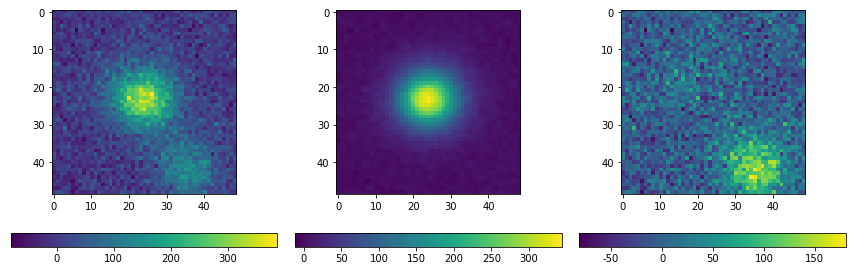

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=False, sharey=False, gridspec_kw=None)
im = axs[0].imshow(scut.data - sky)
colorbaring(fig,axs[0], im)
im = axs[1].imshow(fit(xx_sub, yy_sub))
colorbaring(fig,axs[1], im)
im = axs[2].imshow(scut.data - sky - fit(xx_sub, yy_sub))
colorbaring(fig,axs[2], im)

plt.tight_layout()

np.sum(fit(xx_sub, yy_sub))


Stetson 1987 PASP 99 191 p.206:
> Thus it is clear that, for these frames at least, solving explicitly for the local diffuse sky brightness produces consistently more photometric scatter at the cost of greater effort than simply adopting the modal value found in a surrounding annulus of pixels, even though the latter method is fundamentally wrong.

For IRAF implementation:
* [psf](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?psf): manual of "how to psf"
* [daopars](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?daopars): weighting function implementation


Text(0.5, 1.0, 'Original')

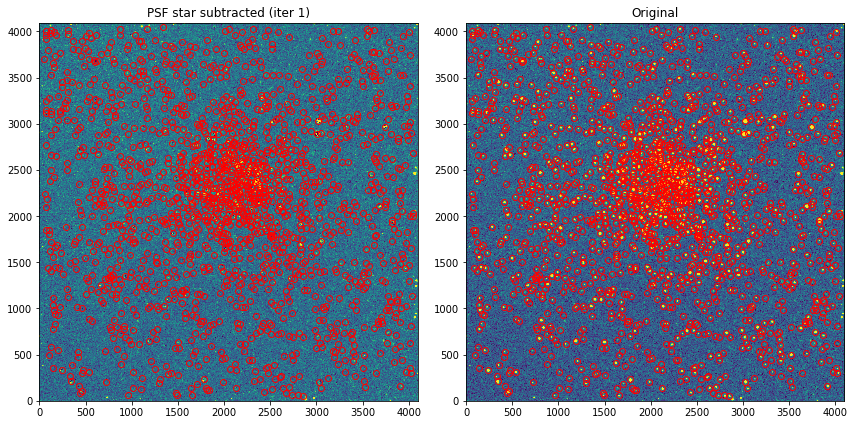

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=False, sharey=False, gridspec_kw=None)
zimshow(axs[0], data - data_staronly)
zimshow(axs[1], data)
# axs[1].imshow(data / (data - data_staronly), vmin=-2, vmax=+2)
axs[0].plot(phot["xcenter"], phot["ycenter"], 'ro', mfc='none')
axs[1].plot(phot["xcenter"], phot["ycenter"], 'ro', mfc='none')
plt.tight_layout()

axs[0].set_title("PSF star subtracted (iter 1)")
axs[1].set_title("Original")

### Test Plot for a Star

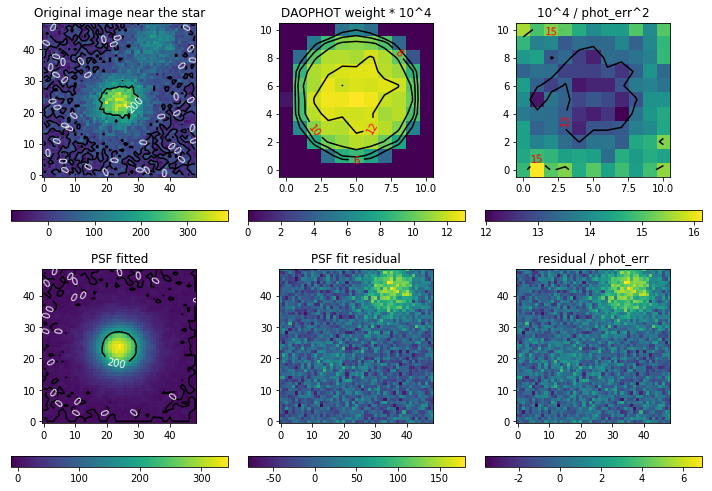

In [41]:
model_fitted = fit(xx_sub, yy_sub)
scut_skysub = scut.data - sky
scut_err = Cutout2D(err, position=pos_fit, size=psf_size).data
residual = scut_skysub - model_fitted

fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=False, sharey=False, gridspec_kw=None)
axo = axs[0, 0]  # original
axd = axs[0, 1]  # DAOphot weight
d = 1.e+4 * astropy_weight**2
axp = axs[0, 2]  # phot error
p = 1.e+4 / fcut_err**2
axf = axs[1, 0]  # fit
axr = axs[1, 1]  # residual
ax1 = axs[1, 2]  # residual / phot err

im = axo.imshow(scut_skysub, origin="lower")
cs = axo.contour(scut_skysub, colors='k', levels=np.arange(0, 1000, 200))
axo.clabel(cs, inline=1, colors='w', fmt="%.0f")
axo.set_title("Original image near the star")
colorbaring(fig, axo, im)

im = axd.imshow(d, origin="lower")
cs = axd.contour(d, colors='k', levels=np.arange(d.max() - 7, d.max()+3, 2))
axd.clabel(cs, inline=1, colors='r', fmt="%.0f")
axd.set_title("DAOPHOT weight * 10^4")
colorbaring(fig, axd, im)

im = axp.imshow(p, origin="lower")
cs = axp.contour(p, colors='k', levels=np.arange(p.max() - 7, p.max()+3, 2))
axp.clabel(cs, inline=1, colors='r', fmt="%.0f")
axp.set_title("10^4 / phot_err^2")
colorbaring(fig, axp, im)

im = axf.imshow(model_fitted, origin='lower')
cs = axf.contour(model_fitted, colors='k', levels=np.arange(0, 1000, 200))
axf.clabel(cs, inline=1, colors='w', fmt="%.0f")
axf.set_title("PSF fitted")
colorbaring(fig, axf, im)

im = axr.imshow(residual, origin='lower')
axr.set_title("PSF fit residual")
colorbaring(fig, axr, im)

im = ax1.imshow(residual / scut_err, origin='lower')
ax1.set_title("residual / phot_err")
colorbaring(fig, ax1, im)

plt.tight_layout()

### Save

In [54]:
ccd_1 = ccd.copy()
ccd_1.data = data - data_staronly
ccd_1.uncertainty = None
ccd_1.header["PSFITER"] = 1
ccd_1 = yfu.CCDData_astype(ccd=ccd_1, dtype='float32')
ccd_1.write("tmp/SNUO_STX16803-M11-1-1-20190507-171622-V-60.0_CR_PSF_01.fits", overwrite=True)

## 2nd Iteration

654.6596069335938 682.0429077148438 38.494476318359375 489.5705261230469
339 star groups out of 412 stars


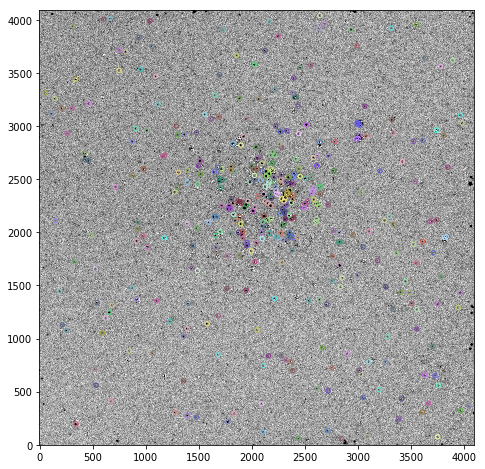

<Figure size 432x288 with 0 Axes>

In [31]:
data = ccd_1.data

avg, med, std = sigma_clipped_stats(data, sigma=3, maxiters=10, std_ddof=1)
threshold = med - 5 * std
print(avg, med, std, threshold)

finder = DAOStarFinder(fwhm=fwhm, threshold=threshold,
                       sharplo=0., sharphi=2.0,   # default values 0.2 and 1.0
                       roundlo=-1.0, roundhi=1.0,  # default values -1 and +1
                       sigma_radius=2.5,           # default values 1.5
                       ratio=1.0,                  # 1.0: circular gaussian
                       exclude_border=True)        # To exclude sources near edges

# The DAOStarFinder object ``finder`` gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
found = finder(data)

# Select only the stars NOT at the edges (bezel) of the image
found = found[(found["xcentroid"] > psf_size)
             & (found["xcentroid"] < ccd.header["NAXIS1"] - psf_size)
             & (found["ycentroid"] > psf_size)
             & (found["ycentroid"] < ccd.header["NAXIS2"] - psf_size)]

# This needs to be updated by photutils....
found["id"] = np.arange(len(found)) + 1  

star_groups = ypu.group_stars(table=found,
                              crit_separation=2.8 * fwhm, 
                              xcol="xcentroid",
                              ycol="ycentroid",
                              index_only=False)

coords_SF = (found['xcentroid'], found['ycentroid'])
ap_found = CAp(coords_SF, r=25) 

print(f"{len(star_groups.groups)} star groups out of {len(star_groups)} stars")

fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharex=False, sharey=False, gridspec_kw=None)
zimshow(axs, data, cmap="gray_r")

for i, group in enumerate(star_groups.groups):
    xypos = np.transpose([group['x_0'], group['y_0']])
    ap = CAp(xypos, r=20)
    ap.plot(color=cmap.colors[i%256], lw=1)
plt.show()

plt.tight_layout()

In [43]:
xypos = np.transpose([star_groups['x_0'], star_groups['y_0']])
ap = CAp(xypos, r=r_fit)
an = CAn(xypos, r_in=r_in, r_out=r_out)
phot = ypu.apphot_annulus(ccd, aperture=ap, annulus=an, error=err,
                          sky_keys={"mode_option":"MMM"})
phot["group_id"] = star_groups["group_id"]
phot = Table(phot)

stars_02 = dict(id=[], group_id=[], x=[], y=[], flux=[])
data_staronly = np.zeros_like(data)
xx_all, yy_all = np.mgrid[:data_staronly.shape[1], :data_staronly.shape[0]]

phot_g = phot.group_by("group_id")
for i, group in enumerate(phot_g):
    clear_output(wait = True)
    if i % 10 == 0:
        print(f"PSF... {i} ~ {i + 10} / {len(phot_g)}")
    
    group = Table(group)
    sky = np.mean(group["msky"])  # use avg sky; see comment below.
    for row in group:
        pos_init = np.transpose([row["xcenter"], row["ycenter"]])
        result = ypu.dao_nstar(data=data, position=pos_init, r_fit=r_fit, psf=psf_init,
                               flux_init=row["source_sum"], sky=sky, err=err, full=True)
        fit, pos_fit, fitter, astropy_weight, fcut, fcut_skysub, fcut_err = result
        stars_02["id"].append(row["id"])
        stars_02["group_id"].append(row["group_id"])
        stars_02["x"].append(pos_fit[0])
        stars_02["y"].append(pos_fit[1])
        stars_02["flux"].append(fit.flux.value)
        
        scut = Cutout2D(data, position=pos_fit, size=psf_size, mode='partial')  # "subtraction" cut
        fit.x_0, fit.y_0 = scut.to_cutout_position(pos_fit)
        
        yy_sub, xx_sub = np.mgrid[:psf_size, :psf_size]
        star = fit(xx_sub, yy_sub)
        data_staronly[scut.slices_original] += star

PSF... 410 ~ 420 / 412


In [44]:
stars_02_tab = Table(stars_02)
stars_02_tab.write("tmp/psfphot_02.csv")
stars_02_tab

<Table length=412>
  id  group_id         x                  y                 flux       
int64  int64        float64            float64            float64      
----- -------- ------------------ ------------------ ------------------
    1        1 2841.5367647973962   60.6484275622701  322832.8176307139
    2        2  2439.903557253848  61.48950652183618 293440.24359058915
    3        3  3751.109484320093  76.22960635108507 288008.93333259557
    4        4  3085.708895344024  76.69173172116056  307921.5228382603
    5        5 2102.9645353127125 123.06642323988893   323508.669648339
    6        6 2718.4529738889546  135.4879489302143  354214.1889166077
    7        7  344.7114348180391 196.24464673548061 1097942.5752694549
    8        8 1774.8408634975904 219.53891164762518  1880086.714686413
    9        9  3383.347499069596  243.1663789259672  308745.8536234234
   10       10 1478.4349117587994  260.4876886248931 294436.69188121107
  ...      ...                ...                ...                ...
  403      330  2633.856901850894 3924.2915857793537  294841.6817752255
  404      331 3312.1724298189265 3925.0324609348777 358918.24587390694
  405      332   316.521149470262 3944.6374265526047  328458.9780221851
  406      333 3551.6239251468314  3957.580750446081 426955.90156279266
  407      334  2686.030567337473  3968.650493373754  319501.1480973836
  408      335 2163.9633559770627 3989.5469854538733  284281.4298075562
  409      336 1041.0865903980555  3992.427858237858 330796.99523034866
  410      337   603.303009791978  4008.699861094753  299777.7513061392
  411      338  665.7928606691141  4014.935354942015 307448.97828256496
  412      339 2640.0332803310835  4045.330961410393 306521.28693505604

Text(0.5, 1.0, 'Original')

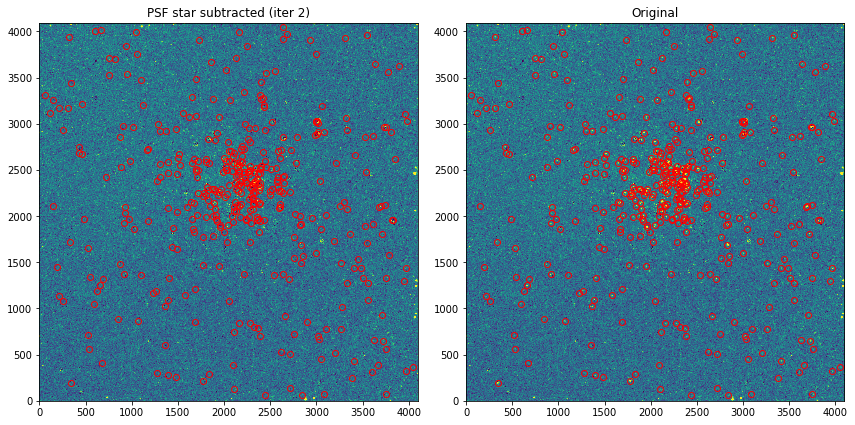

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=False, sharey=False, gridspec_kw=None)
zimshow(axs[0], data - data_staronly)
zimshow(axs[1], data)
# axs[1].imshow(data / (data - data_staronly), vmin=-2, vmax=+2)
axs[0].plot(phot["xcenter"], phot["ycenter"], 'ro', mfc='none')
axs[1].plot(phot["xcenter"], phot["ycenter"], 'ro', mfc='none')
plt.tight_layout()

axs[0].set_title("PSF star subtracted (iter 2)")
axs[1].set_title("Original")

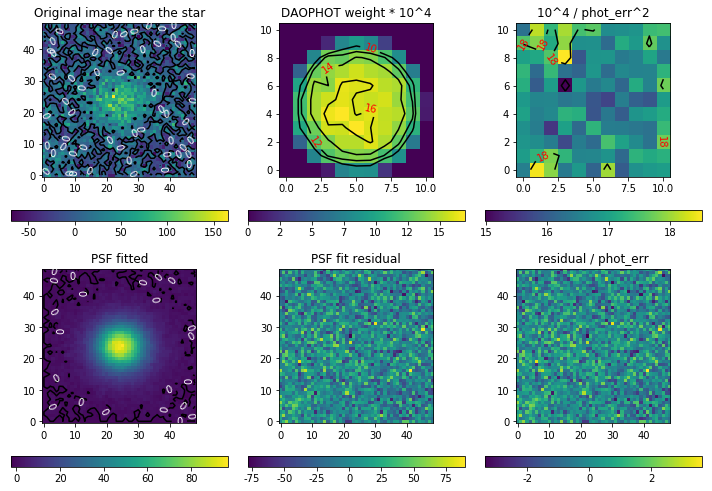

In [46]:
model_fitted = fit(xx_sub, yy_sub)
scut_skysub = scut.data - sky
scut_err = Cutout2D(err, position=pos_fit, size=psf_size).data
residual = scut_skysub - model_fitted

fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=False, sharey=False, gridspec_kw=None)
axo = axs[0, 0]  # original
axd = axs[0, 1]  # DAOphot weight
d = 1.e+4 * astropy_weight**2
axp = axs[0, 2]  # phot error
p = 1.e+4 / fcut_err**2
axf = axs[1, 0]  # fit
axr = axs[1, 1]  # residual
ax1 = axs[1, 2]  # residual / phot err

im = axo.imshow(scut_skysub, origin="lower")
cs = axo.contour(scut_skysub, colors='k', levels=np.arange(0, 1000, 200))
axo.clabel(cs, inline=1, colors='w', fmt="%.0f")
axo.set_title("Original image near the star")
colorbaring(fig, axo, im)

im = axd.imshow(d, origin="lower")
cs = axd.contour(d, colors='k', levels=np.arange(d.max() - 7, d.max()+3, 2))
axd.clabel(cs, inline=1, colors='r', fmt="%.0f")
axd.set_title("DAOPHOT weight * 10^4")
colorbaring(fig, axd, im)

im = axp.imshow(p, origin="lower")
cs = axp.contour(p, colors='k', levels=np.arange(p.max() - 7, p.max()+3, 2))
axp.clabel(cs, inline=1, colors='r', fmt="%.0f")
axp.set_title("10^4 / phot_err^2")
colorbaring(fig, axp, im)

im = axf.imshow(model_fitted, origin='lower')
cs = axf.contour(model_fitted, colors='k', levels=np.arange(0, 1000, 200))
axf.clabel(cs, inline=1, colors='w', fmt="%.0f")
axf.set_title("PSF fitted")
colorbaring(fig, axf, im)

im = axr.imshow(residual, origin='lower')
axr.set_title("PSF fit residual")
colorbaring(fig, axr, im)

im = ax1.imshow(residual / scut_err, origin='lower')
ax1.set_title("residual / phot_err")
colorbaring(fig, ax1, im)

plt.tight_layout()

In [55]:
ccd_2 = ccd_1.copy()
ccd_2.data = data - data_staronly
ccd_2.uncertainty = None
ccd_2.header["PSFITER"] = 2
ccd_2 = yfu.CCDData_astype(ccd=ccd_2, dtype='float32')
ccd_2.write("tmp/SNUO_STX16803-M11-1-1-20190507-171622-V-60.0_CR_PSF_02.fits", overwrite=True)